In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engine-data/engine_data.csv


**Import package**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import torch  
import torch.nn as nn  
import torch.optim as optim  

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

2024-06-28 08:18:45.455323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 08:18:45.455515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 08:18:45.632509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Load the training dataset**

In [3]:
engine_df = pd.read_csv("/kaggle/input/engine-data/engine_data.csv")
engine_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


**Preprocessing dataset**

In [4]:
engine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


No data is empty, no other processing is required

In [5]:
engine_df.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000


**Analysis the data:**

The average speed is 791, which means that the main data in the data set is medium and low speed. The coolant temperature has an abnormally high value, which may be due to engine unhealthy.

In [6]:
engine_df["Engine Condition"].value_counts()

Engine Condition
1    12317
0     7218
Name: count, dtype: int64

**Features and Target:**

In [7]:
engine_features = engine_df.drop("Engine Condition", axis=1)
engine_target = engine_df["Engine Condition"]

In [8]:
corr_matrix = engine_df.corr()
corr_matrix["Engine Condition"].sort_values(ascending=False)

Engine Condition    1.000000
Fuel pressure       0.116259
Lub oil pressure    0.060904
Coolant pressure   -0.024054
Coolant temp       -0.046326
lub oil temp       -0.093635
Engine rpm         -0.268201
Name: Engine Condition, dtype: float64

**Explore other features:**

`Ratio of lub oil pressure to fuel pressure = lub oil pressure / fuel pressure`

- Monitors the balance status of the engine's lubrication and fuel systems.

`Coolant Efficiency`

- The relative efficiency or cooling capacity of a coolant per unit speed.
- This indicator may be used to evaluate the performance of the cooling system or as a reference parameter in engine design and maintenance.

`Oil Efficiency`
- This indicator may be used to evaluate the lubrication efficiency of the oil at a specific speed and temperature. 
- If the oil can maintain its lubrication performance under high speed and high temperature conditions, then its "efficiency" is higher. This indicator may be important for evaluating the quality of the oil, the wear of the engine, and predicting the oil change cycle.

In [9]:
# Ratio of lubricating oil pressure to fuel pressure = lubricating oil pressure / fuel pressure -- Monitors the balance status of the engine's lubrication and fuel systems.
engine_df["ratio oil fuel"] = (1 / engine_df["Fuel pressure"]) * engine_df["Lub oil pressure"]

# Coolant Efficiency
engine_df["Coolant Efficiency"] = (1 / engine_df["Engine rpm"]) * engine_df["Coolant temp"]

# Oil Efficiency
engine_df["Oil Efficiency"] = 1 / (engine_df["Engine rpm"] * engine_df["lub oil temp"])

engine_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition,ratio oil fuel,Coolant Efficiency,Oil Efficiency
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1,0.211484,0.116617,0.000017
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0,0.181649,0.094116,0.000015
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1,0.451958,0.153165,0.000025
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1,0.190046,0.151743,0.000029
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0,0.360440,0.140550,0.000021


In [10]:
corr_matrix = engine_df.corr()
corr_matrix["Engine Condition"].sort_values(ascending=False)

Engine Condition      1.000000
Oil Efficiency        0.274301
Coolant Efficiency    0.252389
Fuel pressure         0.116259
Lub oil pressure      0.060904
ratio oil fuel       -0.022968
Coolant pressure     -0.024054
Coolant temp         -0.046326
lub oil temp         -0.093635
Engine rpm           -0.268201
Name: Engine Condition, dtype: float64

In [11]:
X = engine_features.values  
y = engine_target.values
  
# Data Standardization
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  
  
# Split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  
  
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  
  
# Define Feedforward neural network
class FeedForwardNN(nn.Module):  
    def __init__(self, input_size, hidden_size, num_classes):  
        super(FeedForwardNN, self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(hidden_size, num_classes)  
      
    def forward(self, x):  
        out = self.fc1(x)  
        out = self.relu(out)  
        out = self.fc2(out)  
        return out  

# Initialize model parameters  
input_size = X_train.shape[1]  # feature
hidden_size = 5  # hidden layer nodes 
num_classes = 2   
model = FeedForwardNN(input_size, hidden_size, num_classes)  
  
# Loss function and optimizer  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
  
# Train
num_epochs = 200
train_losses = []  
train_accuracies = []  
  
for epoch in range(num_epochs):  
    outputs = model(X_train_tensor)  
    loss = criterion(outputs, y_train_tensor)  
      
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  
      
    train_losses.append(loss.item())  
      
    model.eval()  
    with torch.no_grad():  
        train_outputs = model(X_train_tensor)  
        _, train_predicted = torch.max(train_outputs, 1)  
        train_correct = (train_predicted == y_train_tensor).sum().item()  
        train_accuracy = train_correct / y_train_tensor.size(0)  
    train_accuracies.append(train_accuracy)  
    model.train()  
      
    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Train Accuracy: {train_accuracy:.4f}')  

# Test  
model.eval()
with torch.no_grad(): 
    y_pred = model(X_test_tensor)  
    _, predicted = torch.max(y_pred.data, 1)
    correct = (predicted == y_test_tensor).sum().item() 
    accuracy = correct / y_test_tensor.size(0)
    print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

Epoch [10/200], Loss: 0.6614136695861816, Train Accuracy: 0.6145
Epoch [20/200], Loss: 0.6556850075721741, Train Accuracy: 0.6236
Epoch [30/200], Loss: 0.6506493091583252, Train Accuracy: 0.6303
Epoch [40/200], Loss: 0.6461487412452698, Train Accuracy: 0.6353
Epoch [50/200], Loss: 0.6420643925666809, Train Accuracy: 0.6407
Epoch [60/200], Loss: 0.6383177042007446, Train Accuracy: 0.6438
Epoch [70/200], Loss: 0.6348508596420288, Train Accuracy: 0.6453
Epoch [80/200], Loss: 0.6316581964492798, Train Accuracy: 0.6469
Epoch [90/200], Loss: 0.6287571787834167, Train Accuracy: 0.6486
Epoch [100/200], Loss: 0.6261541247367859, Train Accuracy: 0.6519
Epoch [110/200], Loss: 0.6238385438919067, Train Accuracy: 0.6543
Epoch [120/200], Loss: 0.6217988133430481, Train Accuracy: 0.6555
Epoch [130/200], Loss: 0.6200159192085266, Train Accuracy: 0.6562
Epoch [140/200], Loss: 0.6184684634208679, Train Accuracy: 0.6577
Epoch [150/200], Loss: 0.6171293258666992, Train Accuracy: 0.6601
Epoch [160/200], Lo

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

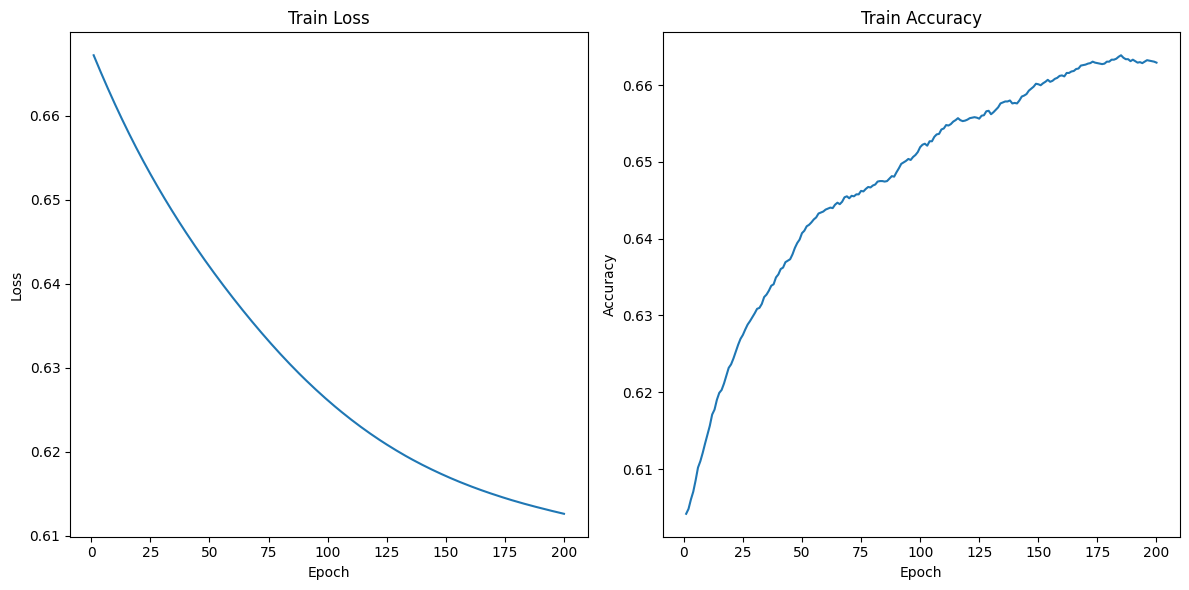

In [12]:
import seaborn as sns  
import pandas as pd  
import matplotlib.pyplot as plt  
  
df = pd.DataFrame({  
    'Epoch': range(1, len(train_losses) + 1),  
    'Loss': train_losses,  
    'Accuracy': train_accuracies  
})  
  

plt.figure(figsize=(12, 6))  
  
# loss pic
plt.subplot(1, 2, 1)  
sns.lineplot(data=df, x='Epoch', y='Loss')  
plt.title('Train Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
  
# accuracy pic
plt.subplot(1, 2, 2)  
sns.lineplot(data=df, x='Epoch', y='Accuracy')  
plt.title('Train Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
  
# layout
plt.tight_layout()  
plt.show()

**Logistic Regression**

In [14]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

validation = log_reg.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.6501151778858459


**Decision Tree Classification**

In [15]:
tree_cls = DecisionTreeClassifier()

tree_cls.fit(X_train, y_train)

validation = tree_cls.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.5774251343742002


**Random Forest Classification**

In [16]:
forest_cls = RandomForestClassifier()

forest_cls.fit(X_train, y_train)

validation = forest_cls.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.6406449961607371
